<a href="https://colab.research.google.com/github/e76971072/Lane-Detection/blob/master/Lane_Detection_Development_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/e76971072/Lane-Detection.git

Cloning into 'Lane-Detection'...
remote: Enumerating objects: 264, done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 264
Receiving objects: 100% (264/264), 146.48 MiB | 13.21 MiB/s, done.


In [ ]:
!git clone https://github.com/wwang/ExploreSTEM.git

Cloning into 'ExploreSTEM'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 114 (delta 0), reused 1 (delta 0), pack-reused 110
Receiving objects: 100% (114/114), 65.40 MiB | 11.55 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)



Mounted at /content/drive


In [ ]:
cd Lane-Detection/supertuxkar2/

/content/Lane-Detection/supertuxkar2


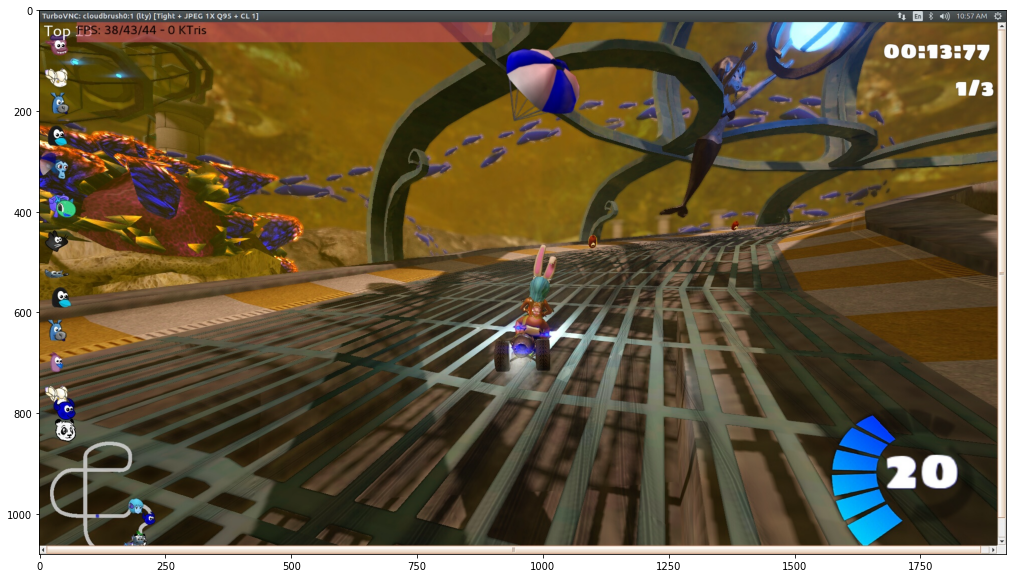

In [ ]:
import cv2
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


plt.rcParams["figure.figsize"] = (40,10)


# images = []
    # # for filename in os.listdir(folder):
img = cv2.imread(os.path.join("/content/Lane-Detection/supertuxkar2/Apr-26-2019-15-57-47.jpg"))
    #     # if img is not None:
    # images.append(img)
plt.imshow(img)




folder="/content/Lane-Detection/supertuxkar2"


### **Define Function To process the image**

In [ ]:
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os
import io
import base64
from IPython.display import HTML








''' Professor Package Code from Github ''''
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (225,) * channel_count
    else:
        ignore_mask_color = 225
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def drawLine(img, imshape, coef, intercept, intersection, color, thickness):
    if not math.isnan(intersection):
        x1, y1 = (int(intersection), int(intersection * coef + intercept))
        if coef > 0:
            x2, y2 = (imshape[1], int(imshape[1] * coef + intercept))
        elif coef < 0:
            x2, y2 = (0, int(0 * coef + intercept))
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def fitLine(slopePoints):
    
    requiredSlopes = []
    requiredIntercepts = []
    if len(slopePoints) == 1:
        return slopePoints[0][0], slopePoints[0][1]
    
    slopes = [each[0] for each in slopePoints]
    meanSlope = np.mean(slopes)
    sdSlope = np.std(slopes)
    
    for eachXY in slopePoints:
        slope = eachXY[0]
        if slope - meanSlope < 1.5 * sdSlope:
            requiredSlopes.append(slope)
            requiredIntercepts.append(eachXY[1])
    if not requiredSlopes:
        requiredSlopes = slopes
        requiredIntercepts = [eachXY[1] for eachXY in slopePoints]
    requiredSlope = np.mean(requiredSlopes)
    requiredIntercept = np.mean(requiredIntercepts)
    return requiredSlope, requiredIntercept

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    imshape = [img.shape[0], img.shape[1]]
    
    posSlope = []
    negSlope = []
    posIntercept = []
    negIntercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1 - y2) / (x1 - x2)
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        posSlope.append([x1, y1])
                        posSlope.append([x2, y2])
                        posIntercept.append([slope, y1-(slope*x1)])
                    elif slope < 0:
                        negSlope.append([x1, y1])
                        negSlope.append([x2, y2])
                        negIntercept.append([slope, y1-(slope*x1)])
    if not posSlope:
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = (y1 - y2)/(x1 - x2)
                if slope > 0:
                    posSlope.append([x1, y1])
                    posSlope.append([x2, y2])
                    posIntercept.append([slope, y1-slope*x1])
    if not negSlope:
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = (y1 - y2)/(x1 - x2)
                if slope < 0:
                    negSlope.append([x1, y1])
                    negSlope.append([x2, y2])
                    negIntercept.append([slope, y1-slope*x1])
    
    posCoef, posIntercept = fitLine(posIntercept)
    negCoef, negIntercept = fitLine(negIntercept)
    
    intersection = (negIntercept - posIntercept) / (posCoef - negCoef)
    
    drawLine(img, imshape, posCoef, posIntercept, intersection, color, thickness)
    drawLine(img, imshape, negCoef, negIntercept, intersection, color, thickness)       
    
def hough_lines(img, rho=2, theta=0.017453292519943295, threshold=15,
                min_line_len=40, max_line_gap=20):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def playvideo(filename):
    video = io.open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
                 </video>'''.format(encoded.decode('ascii')))

def process_image(image):
    imshape = image.shape
    #Convert to grayscale
    grayscaleImage = grayscale(image)
    #plt.imshow(grayscaleImage)
    #Apply gaussian blur
    gaussianImage = gaussian_blur(grayscaleImage, 5)
    #plt.imshow(gaussianImage)
    #Fine the edges in the image
    cannyImage = canny(gaussianImage, 50, 150)
    #plt.imshow(cannyImage)
    #Limit to a region of interest, in this case the lanes
    roiMask = np.array([[(0, imshape[0]), (465, 320), (475, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    edgeMask = region_of_interest(cannyImage, roiMask)
    #Only the required edges are displayed and rest is set to black
    edgeMaskImage = cv2.cvtColor(edgeMask, cv2.COLOR_GRAY2BGR)
    #plt.imshow(edgeMaskImage)
    
    #Hough lines
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 20
    linesImage = hough_lines(edgeMask, rho, theta, threshold, min_line_len, max_line_gap)    
    
    #colorEdges = np.dstack((cannyImage, cannyImage, cannyImage))
    
    result = cv2.addWeighted(image, 0.8, linesImage, 1, 0)
    return result

def gen_roi_mask(imshape):
    roiMask = np.array([[(0, imshape[0]), (465, 320), (475, 320), (imshape[1], imshape[0])]], dtype=np.int32)

    return roiMask
def process_image(image):
    imshape = image.shape
    #Convert to grayscale
    grayscaleImage = grayscale(image)

    #Apply gaussian blur
    gaussianImage =  gaussian_blur(grayscaleImage, 5)

    #Fine the edges in the image
    cannyImage =  canny(gaussianImage, 50, 150)

    #Limit to a region of interest, in this case the lanes
    roiMask = np.array([[(0, imshape[0]), (465, 320), (475, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    edgeMask =  region_of_interest(cannyImage, roiMask)
    #Only the required edges are displayed and rest is set to black
    edgeMaskImage = cv2.cvtColor(edgeMask, cv2.COLOR_GRAY2BGR)
    
    #Hough lines
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 20
    linesImage = hough_lines(edgeMask, rho, theta, threshold, min_line_len, max_line_gap)    
    
    result = cv2.addWeighted(image, 0.8, linesImage, 1, 0)
    return result


def image_grid (image_name):
  return image_name



Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)696320/45929032 bytes (1.5%)1974272/45929032 bytes (4.3%)3751936/45929032 bytes (8.2%)6283264/45929032 bytes (13.7%)9420800/45929032 bytes (20.5%)12869632/45929032 bytes (28.0%)16113664/45929032 bytes (35.1%)19308544/45929032 bytes (42.0%)22822912/45929032 bytes (49.7%)26271744/45929032 bytes (57.2%)29655040/45929032 bytes (64.6%)32980992/45929032 bytes (71.8%)36397056/

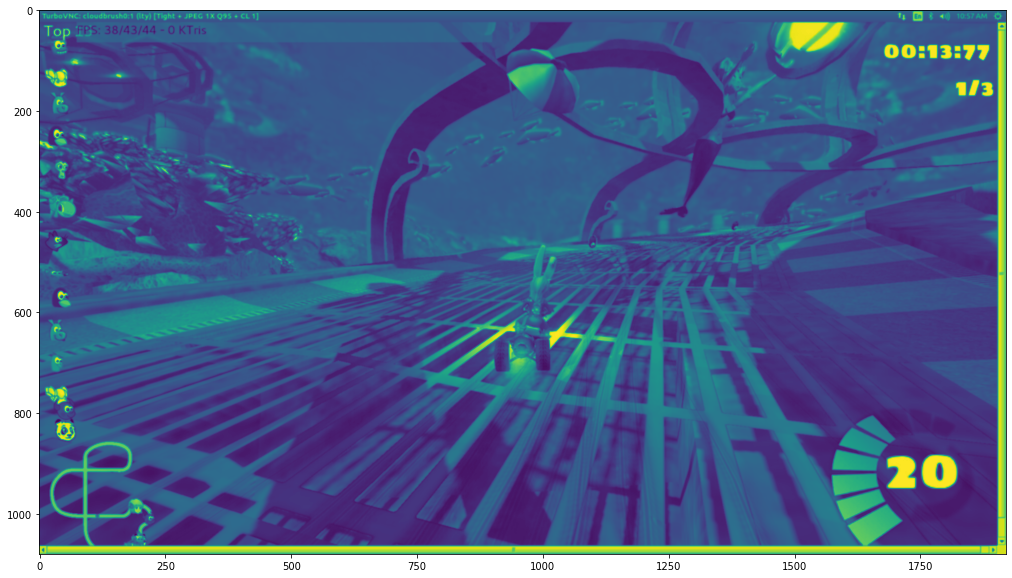

In [ ]:
# edge detection 

import numpy as np




grayscaleImage =  grayscale (img)

#Apply gaussian blur
gaussianImage = gaussian_blur(grayscaleImage, 5)
plt.imshow(gaussianImage)


In [ ]:
marked_img = process_image(image)
plt.imshow(marked_img)

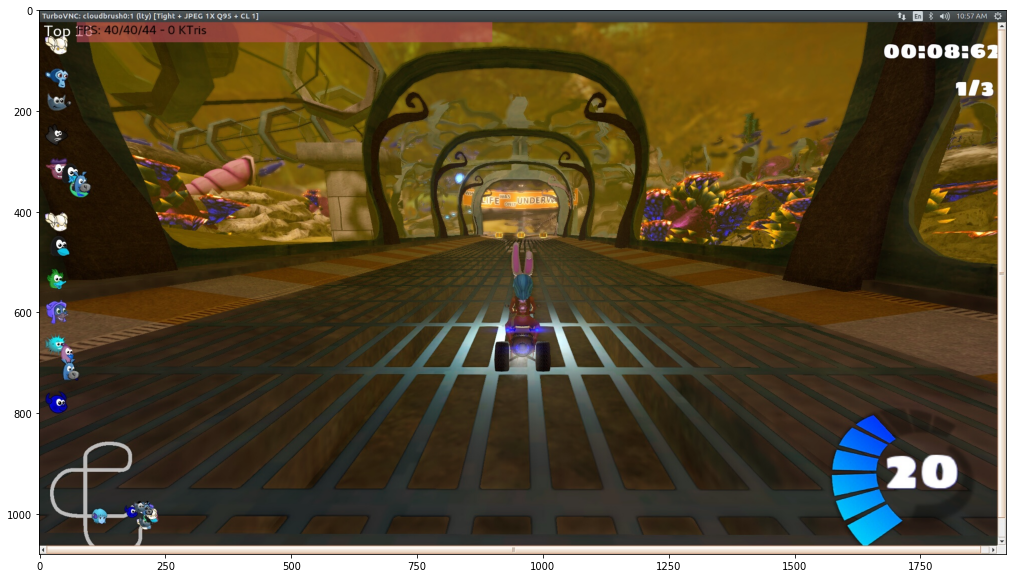

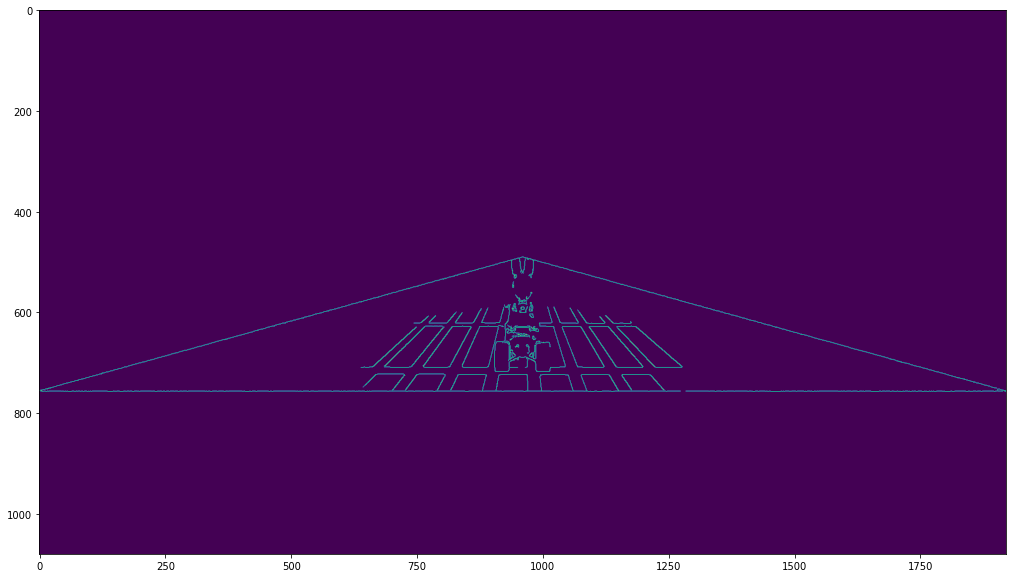

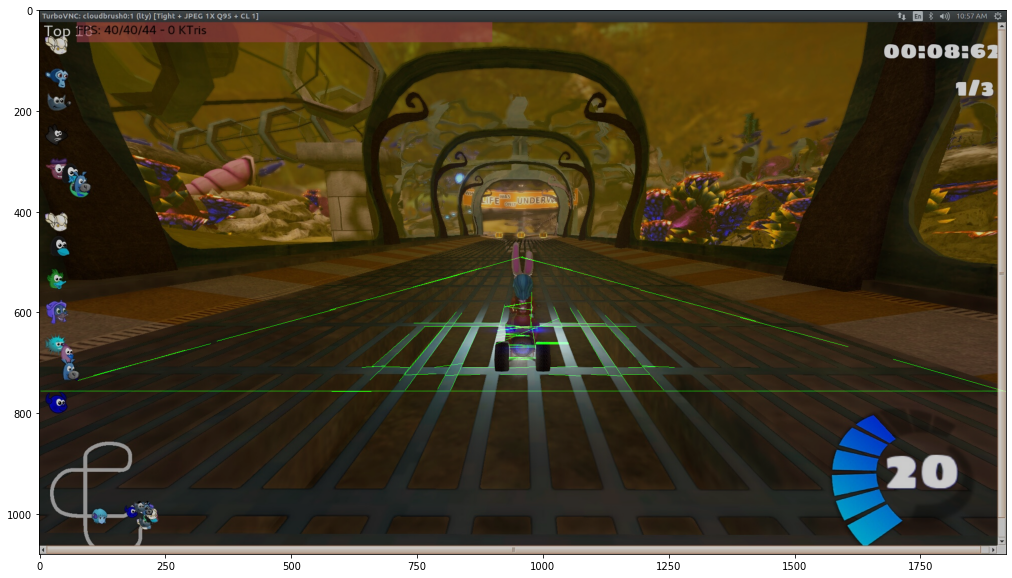

In [152]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

from google.colab.patches import cv2_imshow


image = cv2.imread("/content/Lane-Detection/supertuxkar2/Apr-26-2019-15-57-42.jpg")


plt.imshow (image)

plt.show()

#define region of interest in the picture 
def region_of_interest (img, verticles):
  mask = np.zeros_like(img)
  channel_count = img.shape[2]
  match_mask_color = (255,) * channel_count
  cv2.fillPoly (mask, np.int32([verticles]), match_mask_color)
  masked_image = cv2.bitwise_and (img, mask)
  return masked_image 



def draw_the_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(blank_image, (x1,y1), (x2,y2), (0, 255, 0), thickness=1)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img


height = image.shape[0]
width = image.shape [1]
region_verticles = [
     (0, height * 0.70  ), 
     (width/2, height/2.2),
     (width, height * 0.70  )                
]


gray_image = cv2.cvtColor (masked_image, cv2.COLOR_RGB2GRAY)
canny_image = cv2.Canny (gray_image, 100,200)

masked_image = region_of_interest(img, region_verticles)




plt.imshow(canny_image)
plt.show()


lines = cv2.HoughLinesP(canny_image,
                        rho=6,
                        theta=np.pi/180,
                        threshold=160,
                        lines=np.array([]),
                        minLineLength=40,
                        maxLineGap=25)




image_with_lines = draw_the_lines(image, lines)
plt.imshow(image_with_lines)
plt.show()


(1080, 1920, 3)


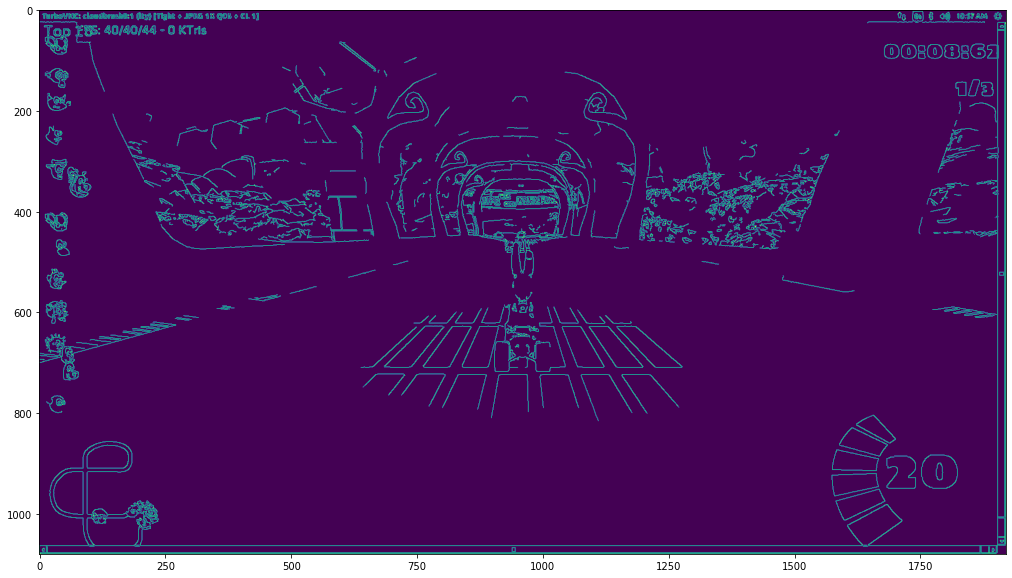

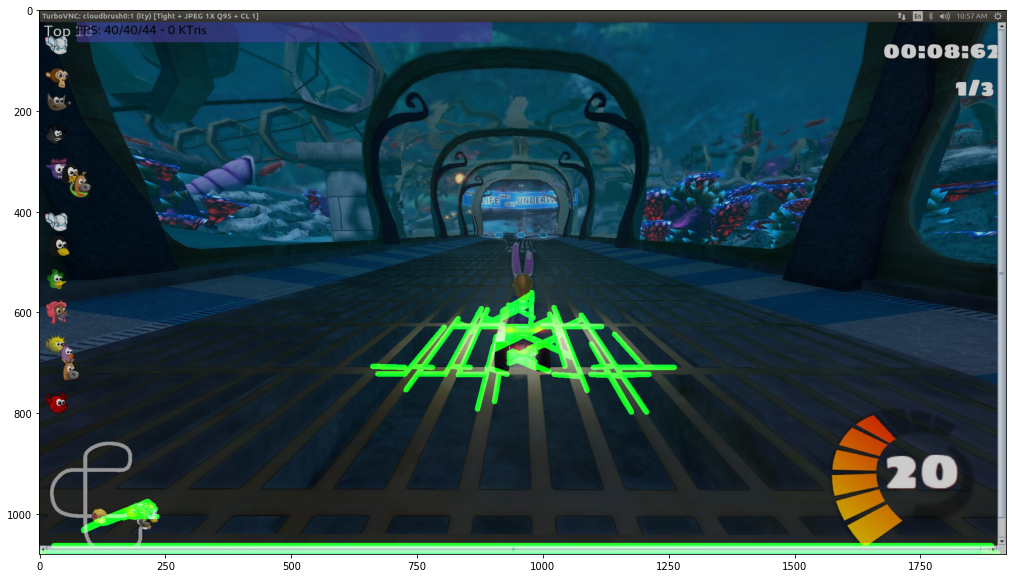

In [126]:
import matplotlib.pylab as plt
import cv2
import numpy as np

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    #channel_count = img.shape[2]
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


image = cv2.imread('/content/Lane-Detection/supertuxkar2/Apr-26-2019-15-57-42.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
height = image.shape[0]
width = image.shape[1]

region_verticles = [
     (0, height * 0.70), 
     (width/2, height/2.2),
     (width, height * 0.70)                
]


gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
canny_image = cv2.Canny(gray_image, 100, 200)



cropped_image = region_of_interest(canny_image,
                np.array([region_of_interest_vertices], np.int32),)

plt.imshow(canny_image)
plt.show()
lines = cv2.HoughLinesP(cropped_image,
                        rho=6,
                        theta=np.pi/180,
                        threshold=160,
                        lines=np.array([]),
                        minLineLength=40,
                        maxLineGap=25)

image_with_lines = drow_the_lines(image, lines)
plt.imshow(image_with_lines)
plt.show()